In [1]:
from model import MAGNN_nc_mb
import pickle
from utils.data import load_PPMI_data
from utils.tools import index_generator, evaluate_results_nc, parse_minibatch

from sklearn.manifold import TSNE

import torch
import numpy as np
import matplotlib.pyplot as plt
import data_utils as du
data_dir = du.find_data_dir('app')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
/home/service/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()
features_list = [torch.FloatTensor(features).to(device) for features in features_list]

n_metapaths = 2
etypes_list = [[0, 1, 0], [0, 1, 1, 0]]
hidden_dim = 64
out_dim = 3
num_heads = 8
attn_vec_dim = 128
dropout_rate = 0.5
batch_size = 8
neighbor_samples = 100
rnn_type = 'RotatE0'

in_dims = [features.shape[0] for features in features_list]
in_dims[0] = features_list[0].shape[1]
for i in range(1, len(features_list)):
    dim = features_list[i].shape[0]
    indices = np.vstack((np.arange(dim), np.arange(dim)))
    indices = torch.LongTensor(indices)
    values = torch.FloatTensor(np.ones(dim))
    features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)

labels = torch.LongTensor(labels).to(device)
            
net = MAGNN_nc_mb(n_metapaths, 2, etypes_list, in_dims, hidden_dim, out_dim, num_heads, attn_vec_dim, rnn_type, dropout_rate)

train_idx = train_val_test_idx['train_idx']
train_idx = np.sort(train_idx)
test_idx = train_val_test_idx['test_idx']
test_idx = np.sort(test_idx)
val_idx = train_val_test_idx['val_idx']
val_idx = np.sort(val_idx)

net.load_state_dict(torch.load(f'checkpoint/checkpoint_PPMI.pt'))

<All keys matched successfully>

In [3]:
def evaluate_model(idx, train_val_test):
    print(f'Evaluating results for {train_val_test}')
    idx_generator = index_generator(batch_size=batch_size, indices=idx, shuffle=False)
    net.eval()
    embeddings = []
    with torch.no_grad():
        for iteration in range(idx_generator.num_iterations()):
            # forward
            idx_batch = idx_generator.next()
            g_list, indices_list, idx_batch_mapped_list = parse_minibatch(adjlists,
                                                                                         edge_metapath_indices_list,
                                                                                         idx_batch,
                                                                                         device, neighbor_samples)
            logits, embeddings_i = net((g_list, features_list, type_mask, indices_list, idx_batch_mapped_list))
            embeddings.append(embeddings_i)
        embeddings = torch.cat(embeddings, 0)
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
            embeddings.cpu().numpy(), labels[idx].cpu().numpy(), num_classes=out_dim)   
    print('')
    return embeddings

train_embeddings = evaluate_model(train_idx, 'Train')
val_embeddings = evaluate_model(val_idx, 'Val')    
test_embeddings = evaluate_model(test_idx, 'Test')    

Evaluating results for Train


/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Keyword arguments ['multigraph'] are deprecated in v0.5, and can be safely removed in all cases.
  return warnings.warn(message, category=category, stacklevel=1)


SVM test
Macro-F1: 0.781464~0.079690 (0.8), 0.765714~0.041946 (0.6), 0.735778~0.028393 (0.4), 0.669378~0.055569 (0.2)
Micro-F1: 0.784211~0.072356 (0.8), 0.767568~0.042218 (0.6), 0.738182~0.028401 (0.4), 0.673973~0.038649 (0.2)
K-means test
NMI: 0.121989~0.009041
ARI: 0.088575~0.008442

Evaluating results for Val
SVM test


/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Keyword arguments ['multigraph'] are deprecated in v0.5, and can be safely removed in all cases.
  return warnings.warn(message, category=category, stacklevel=1)


Macro-F1: 0.242199~0.110446 (0.8), 0.205771~0.069219 (0.6), 0.250513~0.069074 (0.4), 0.277095~0.033519 (0.2)
Micro-F1: 0.307692~0.137604 (0.8), 0.240000~0.091214 (0.6), 0.289189~0.068427 (0.4), 0.332653~0.020510 (0.2)
K-means test
NMI: 0.018293~0.001293
ARI: -0.004097~0.006304

Evaluating results for Test


/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/service/.local/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Keyword arguments ['multigraph'] are deprecated in v0.5, and can be safely removed in all cases.
  return warnings.warn(message, category=category, stacklevel=1)


SVM test
Macro-F1: 0.357379~0.112166 (0.8), 0.363236~0.053600 (0.6), 0.376612~0.047463 (0.4), 0.320356~0.067909 (0.2)
Micro-F1: 0.400000~0.106904 (0.8), 0.381481~0.043979 (0.6), 0.387500~0.049054 (0.4), 0.330189~0.065496 (0.2)
K-means test
NMI: 0.071678~0.000000
ARI: 0.024657~0.000000



In [4]:
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)
CCS = dataloader.y

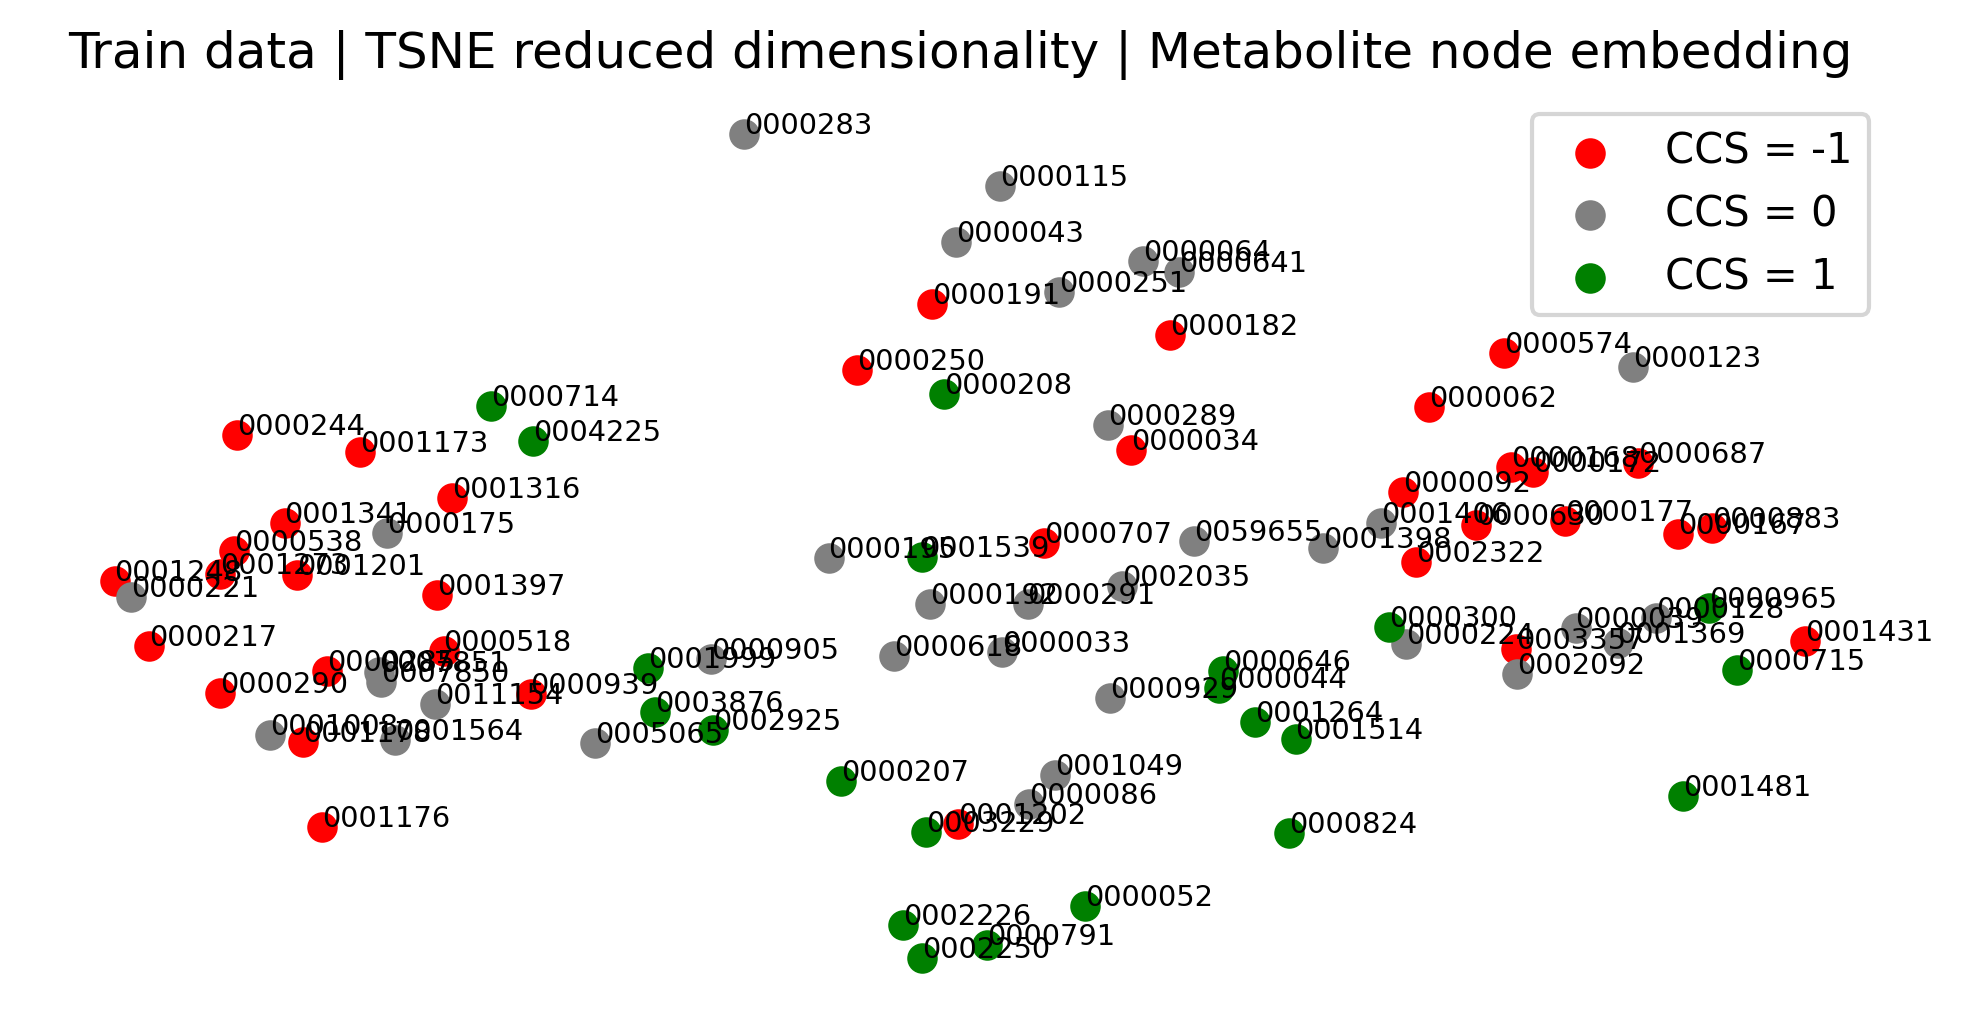

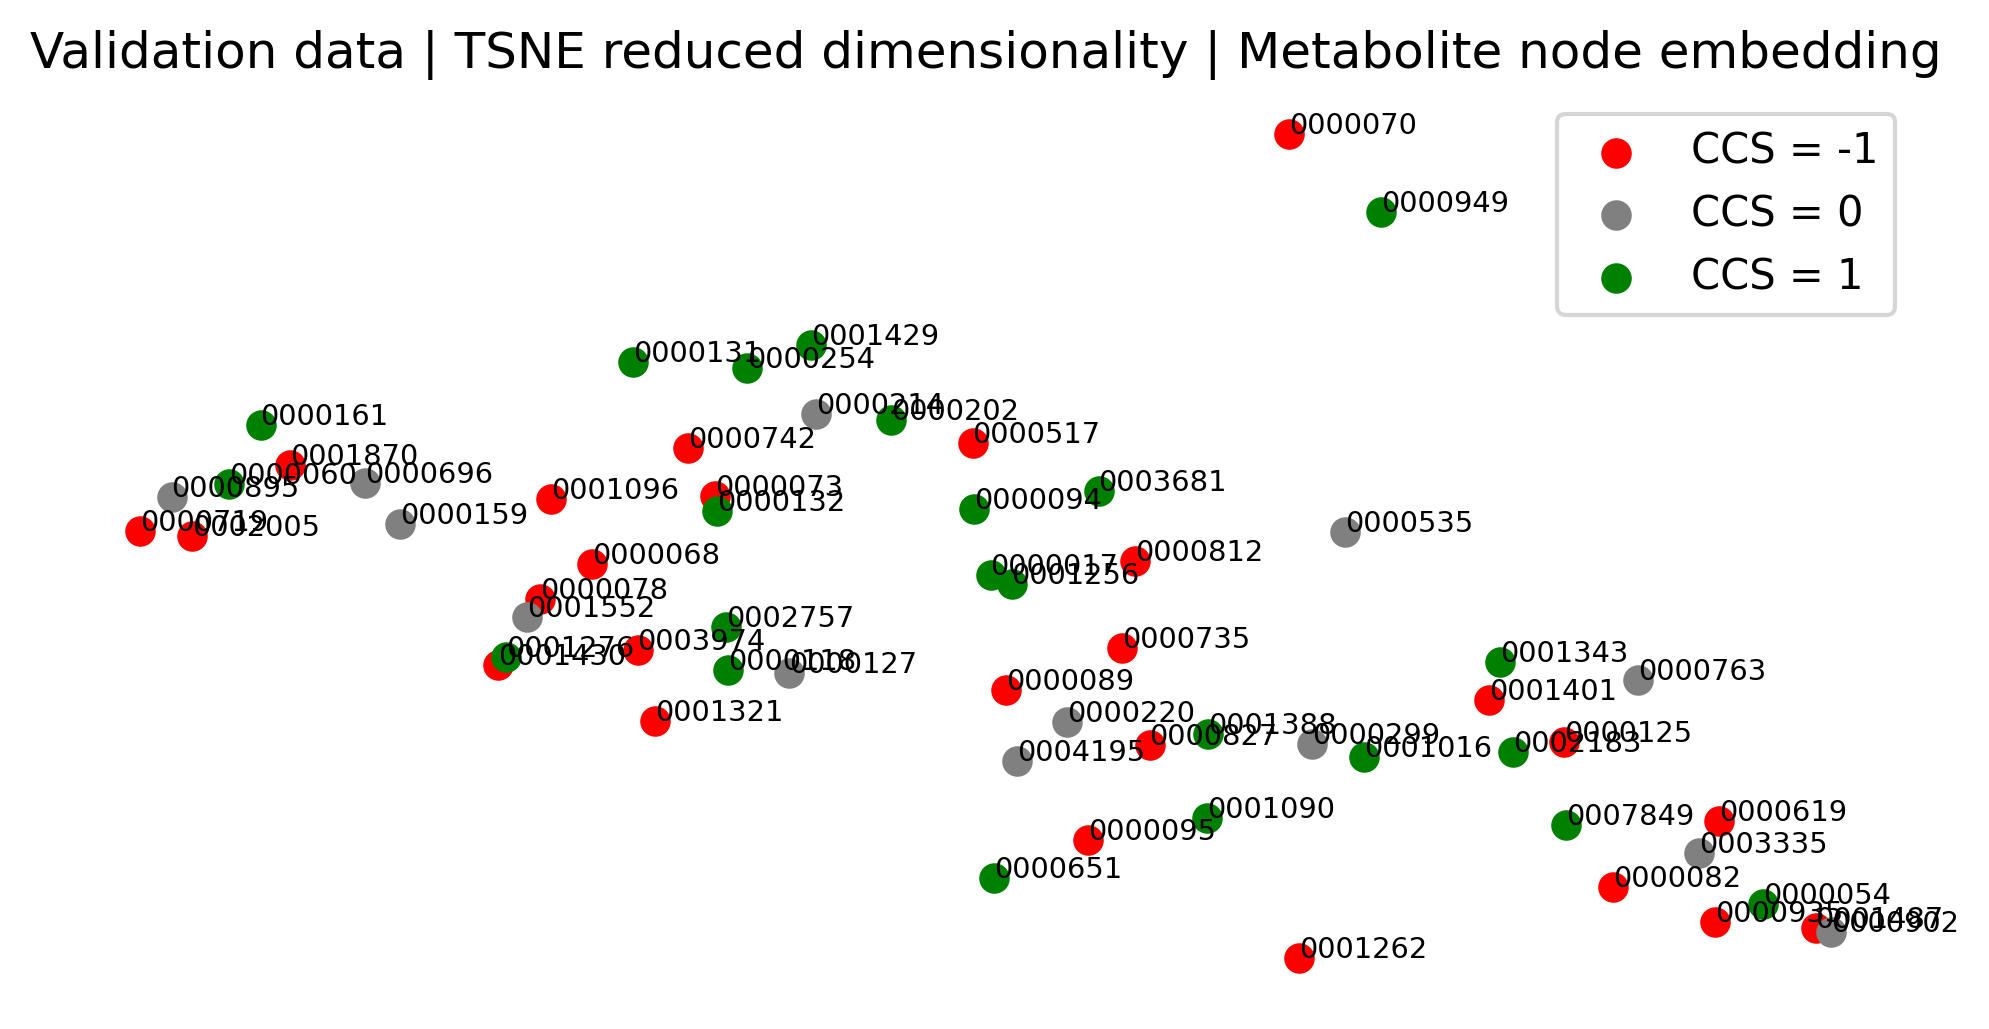

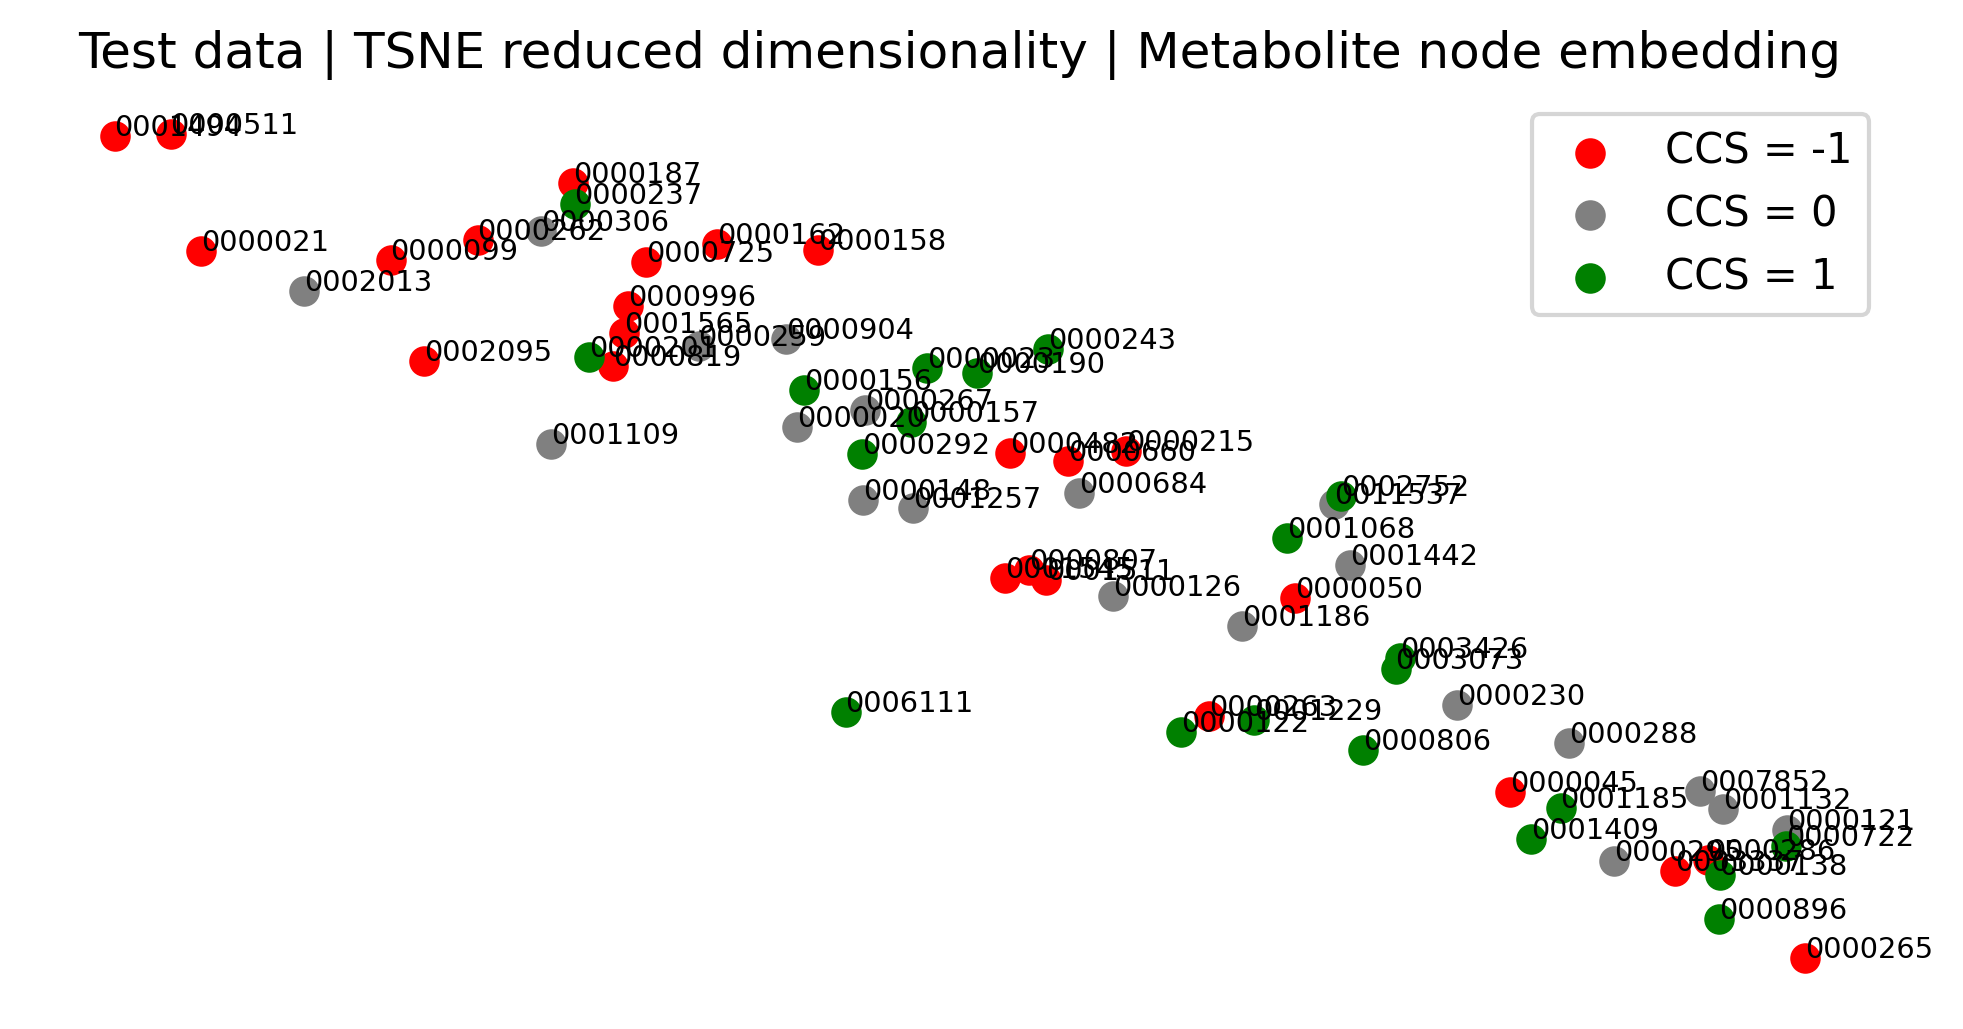

In [6]:
def plot_embedding(embeddings, labels, idx, train_test, method='TSNE', plot_labels=False, CCS=None, highlighted=[]):
    if method=='PCA':
        embedding_2d = torch.pca_lowrank(embeddings, 2)[0]
    elif method=='TSNE':
        embedding_2d = TSNE(n_components=2).fit_transform(embeddings)
    else:
        pass
    
    metabolite_down_mask = np.argwhere(labels[idx]==0)
    metabolite_equal_mask = np.argwhere(labels[idx]==1.)
    metabolite_up_mask = np.argwhere(labels[idx]==2.)

    X_down = embedding_2d[:, 0][metabolite_down_mask][0]
    Y_down = embedding_2d[:, 1][metabolite_down_mask][0]

    X_equal = embedding_2d[:, 0][metabolite_equal_mask][0]
    Y_equal = embedding_2d[:, 1][metabolite_equal_mask][0]
    
    X_up = embedding_2d[:, 0][metabolite_up_mask][0]
    Y_up = embedding_2d[:, 1][metabolite_up_mask][0]
    
    plt.figure(figsize=(8,4), dpi=300)
    
    size = 40
    
    plt.scatter(X_down, Y_down, s=size, c='red', label='CCS = -1')
    plt.scatter(X_equal, Y_equal, s=size, c='gray', label='CCS = 0')
    plt.scatter(X_up, Y_up, s=size, c='green', label='CCS = 1')
    
    if plot_labels:
        fontsize='x-small'
        xy_idx_list_down = list(zip(X_down, Y_down, idx[metabolite_down_mask][0]))
        for x, y, i in xy_idx_list_down:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)

        xy_idx_list_equal = list(zip(X_equal, Y_equal, idx[metabolite_equal_mask][0]))
        for x, y, i in xy_idx_list_equal:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
            
        xy_idx_list_up = list(zip(X_up, Y_up, idx[metabolite_up_mask][0]))
        for x, y, i in xy_idx_list_up:
            if len(highlighted)==0 or (len(highlighted) > 0 and CCS.index[i] in highlighted):
                plt.text(x, y, CCS.index[i][4:], fontsize=fontsize)
    
    plt.legend()
    
    plt.title(f'{train_test} data | {method} reduced dimensionality | Metabolite node embedding')
    plt.axis('off')
    plt.show()   
    return embedding_2d, metabolite_down_mask, idx

# highlighted = ['HMDB0000684', 'HMDB0000161']
highlighted=[]

res = plot_embedding(train_embeddings, labels, train_idx, 'Train', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)
res = plot_embedding(val_embeddings, labels, val_idx, 'Validation', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)
res = plot_embedding(test_embeddings, labels, test_idx, 'Test', method='TSNE', plot_labels=True, CCS=CCS, highlighted=highlighted)

### Experimentation

In [98]:
features_list[0].shape

torch.Size([218, 445])

In [13]:
train_embeddings.shape
val_embeddings.shape
test_embeddings.shape

torch.Size([66, 512])

In [35]:
from matplotlib_venn import venn2

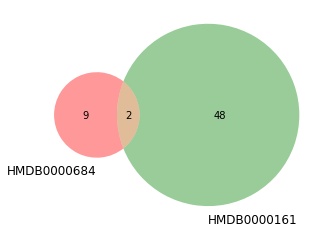

In [95]:
def plot_venn_protein_links(metabolite_A, metabolite_B):
    set_a = set(list(dataloader.PPMI_pruned[metabolite_A]))
    set_b = set(list(dataloader.PPMI_pruned[metabolite_B]))

    # Second way
    v = venn2([set_a, set_b], set_labels = (metabolite_A, metabolite_B))
    plt.show()

plot_venn_protein_links('HMDB0000684', 'HMDB0000161')

In [59]:
dataloader.PPMI_pruned['HNRNPU']
dataloader.PPMI_pruned['KYNU']

AtlasView({'HMDB0000161': {}, 'RPS6KA1': {}, 'LDHAL6B': {}, 'ADSS': {}, 'NDRG1': {}, 'ASNS': {}, 'NUP210': {}, 'NAGK': {}, 'SEC23IP': {}, 'PPM1G': {}, 'MVD': {}, 'SSU72': {}, 'LYN': {}, 'PEPD': {}, 'SMS': {}, 'CSE1L': {}, 'PALM2': {}, 'SMARCD2': {}, 'BCCIP': {}, 'SGTA': {}, 'GNS': {}, 'C11ORF58': {}, 'LDHA': {}, 'TPM3': {}, 'CNDP2': {}, 'UBC': {}, 'CHORDC1': {}, 'GDA': {}, 'COIL': {}, 'SIRT1': {}, 'SMEK2': {}, 'GSR': {}, 'HMDB0000902': {}, 'HMDB0000684': {}})

In [30]:
dataloader.X.loc['HMDB0000292'].compare(dataloader.X.loc['HMDB0001185'], keep_equal=True)

,self,other
average_molecular_weight,152.110900,399.445000
monisotopic_molecular_weight,152.033425,399.145064
"super_class==""Nucleosides, nucleotides, and analogues""",0.000000,1.000000
"super_class==""Organoheterocyclic compounds""",1.000000,0.000000
"class==""Imidazopyrimidines""",1.000000,0.000000
"class==""5'-deoxyribonucleosides""",0.000000,1.000000
"""Carboxylic acids"" in alternative_parents",0.000000,1.000000
"""1,2-diols"" in alternative_parents",0.000000,1.000000
"""Pentoses"" in alternative_parents",0.000000,1.000000
"""Amino acids"" in alternative_parents",0.000000,1.000000


In [71]:
dataloader.X.loc['HMDB0000902']

average_molecular_weight               663.425100
monisotopic_molecular_weight           663.109122
state=="Solid"                           1.000000
state=="Liquid"                          0.000000
state=="Gas"                             0.000000
                                          ...    
"Retina" in tissue_locations             0.000000
"Basal Ganglia" in tissue_locations      0.000000
"Gall Bladder" in tissue_locations       0.000000
"Spleen" in tissue_locations             0.000000
"Bladder" in tissue_locations            0.000000
Name: HMDB0000902, Length: 1989, dtype: Sparse[float64, 0]

In [72]:
dataloader.y['HMDB0000902']

0

In [74]:
val_idx

array([  0,   1,  12,  28,  29,  30,  32,  39,  46,  54,  55,  56,  59,
        63,  66,  68,  69,  70,  75,  78,  81,  85,  86,  93,  94,  95,
       101, 103, 105, 110, 111, 122, 128, 132, 133, 134, 137, 144, 150,
       155, 159, 160, 163, 164, 165, 167, 171, 178, 182, 188, 191, 192,
       196, 197, 200, 203, 205, 210, 211, 214, 215])